# Estimating $s$ and $p_0$ with MLE using aDNA time series data

The goal is to estimate the selection coefficient $s$ and initial allele frequency $p_0$ using the MLE method, from allele frequency estimates obtained from ancient DNA data of different ages.

In [1]:
library(tidyverse)
library(bdkn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.2.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘bdkn’

The following object is masked from ‘package:ggplot2’:

    %+%



### Function simulating the allele frequency trajectory given $s$, $h$ and $p_0$

It can simulate selection on a single locus or multiple loci.

In [2]:
simulate_selection <- function(p0, s, h, total_time, N_loci = 1, Ne = Inf) {
    # initialize the matrix of allele frequencies at each locus (columns)
    # in each generation (rows)
    if (N_loci > 1) p0 <- rep(p0, N_loci)
    p_trajectory <- matrix(c(p0, rep(0, N_loci * (total_time - 1))),
                           nrow = total_time,
                           byrow = TRUE)

    for (gen in seq_len(total_time)[-1]) {
        p <- p_trajectory[gen - 1, ]
        
        # fitnesses of all three genotypes (rows) at all loci (columns)
        fitnesses <- matrix(
            c(p ^ 2           * (1 + s),
              2 * p * (1 - p) * (1 + h * s),
              (1 - p) ^ 2     * 1),
            nrow = 3,
            byrow = TRUE
        )

        # mean fitness of the whole population at individual loci
        mean_fitness <- apply(fitnesses, 2, sum)
        
        # calculate allele frequencies after selection
        p_next <- (fitnesses[1, ] + 1/2 * fitnesses[2, ]) / mean_fitness
        
        # calculate allele frequencies after binomial sampling (drift)
        if (Ne != Inf) {
            p_next <- rbinom(N_loci, 2 * Ne, p_next) / (2 * Ne)
        }
        
        p_trajectory[gen, ] <- p_next
    }

    p_trajectory
}

### Deterministic solution

To test the iterative results, we will compare them to the prediction of this deterministic function (ignoring the effect of drift) describing allele frequency at a single site as a function of $s$ and time. Eq. II-82 from Felsenstein PDF book adjusted appropriately for different expression of heterozygote fitness: $1 + s$ vs $1 + hs$ where $h = 1/2$ in this case.

In [3]:
deterministic_solution <- function(p0, s, t) {
    p0 * exp(s * t / 2) / (p0 * exp(s * t / 2) + (1 - p0))
}

### Test of the iterative models

As a sanity check, I will test the iterative solution by simulating drift at multiple loci under different modes of selection and comparing the results to the trajectory obtained using deterministic solution above.

In [4]:
simulate_and_plot <- function(p0, s, total_time, N_loci, Ne, h=0.5) {
    traj <- simulate_selection(p0, s, h, total_time, N_loci, Ne)

    # plot the average Nea. ancestry and the prediction from the theory
    print(
        qplot(x = 1:total_time, y = apply(traj, 1, mean), geom = "line",
              xlab = "time [generations]", ylab = "frequency",
              ylim=c(0, 1),
              main="Average frequencies (black) vs single-locus theory (red)") +
        geom_line(
            aes(x = 1:total_time, y = map_dbl(1:total_time, ~ deterministic_solution(p0, s, t = .x))),
            col="red"
        )
    )

    # plot the individual allele frequencies and the prediction from the theory
    print(
        as.data.frame(traj) %>% mutate(gen=1:total_time) %>% gather(allele, freq, -gen) %>%
        ggplot(aes(gen, freq, group=allele)) + ylim(0, 1) +
        ggtitle("Allele frequencies (black) vs single-locus theory (red)") +
        geom_line(size=0.05) +
        geom_line(aes(gen, freq, color = "red"),
                      data = data.frame(
                      gen = 1:total_time,
                      allele = "theory",
                      freq = map_dbl(1:total_time, ~ deterministic_solution(p0, s, t = .x)))) +
        theme(legend.position="none") +
        labs(x = "time [generations]", y = "frequency")
    )

    # plot the SFS of Nea. alleles
    #print(qplot(traj[total_time, ], bins=100, xlim=c(-0.05, 1.05), main="SFS of Nea. introgressed alleles"))
}

### Neutrality

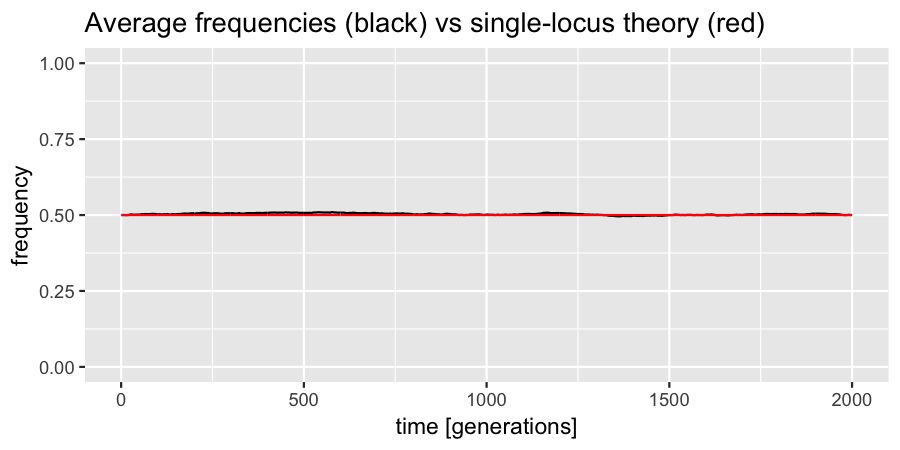

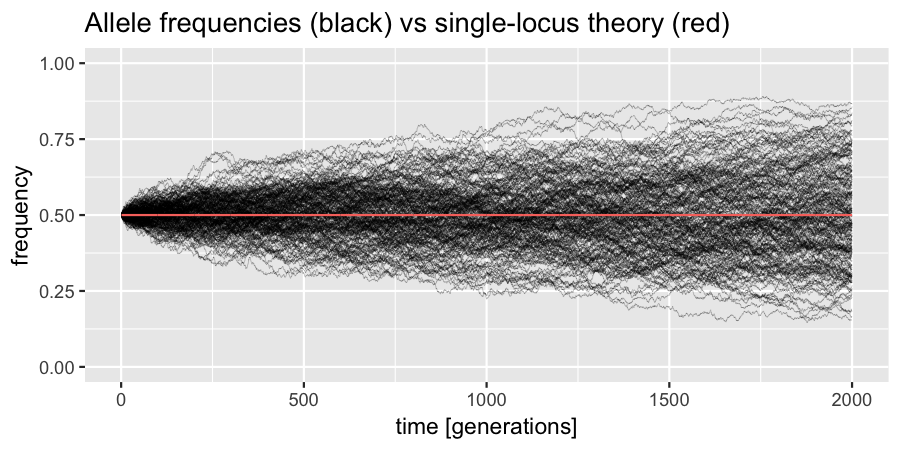

In [5]:
set_dim(6, 3)

simulate_and_plot(p0 = 0.5, s = 0.0, total_time = 2000, N_loci = 200, Ne = 10000)

### Negative selection

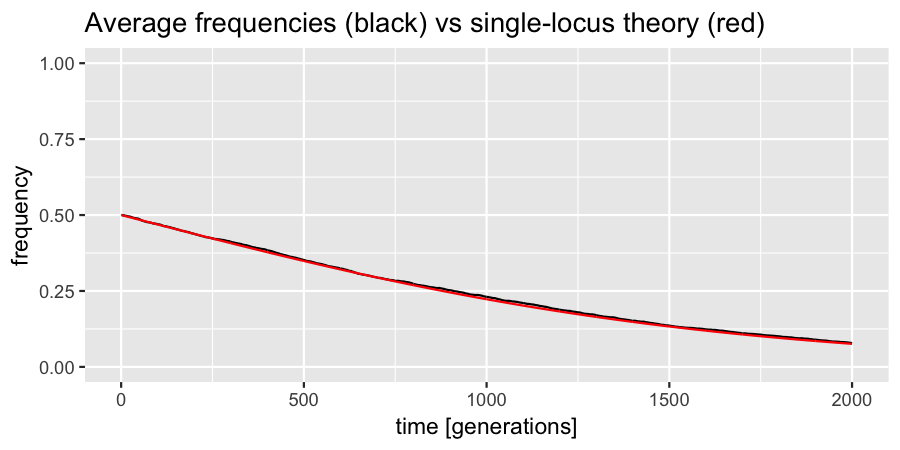

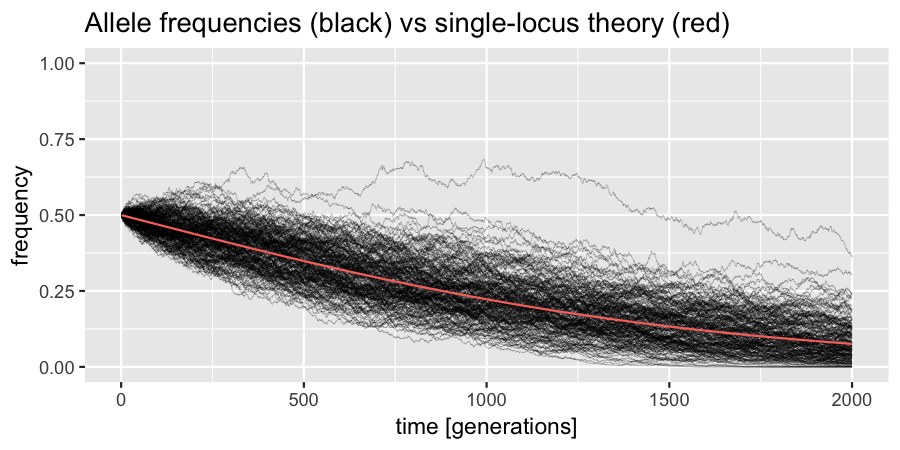

In [6]:
simulate_and_plot(p0 = 0.5, s = -0.0025, total_time = 2000, N_loci = 200, Ne = 10000)

### Positive selection

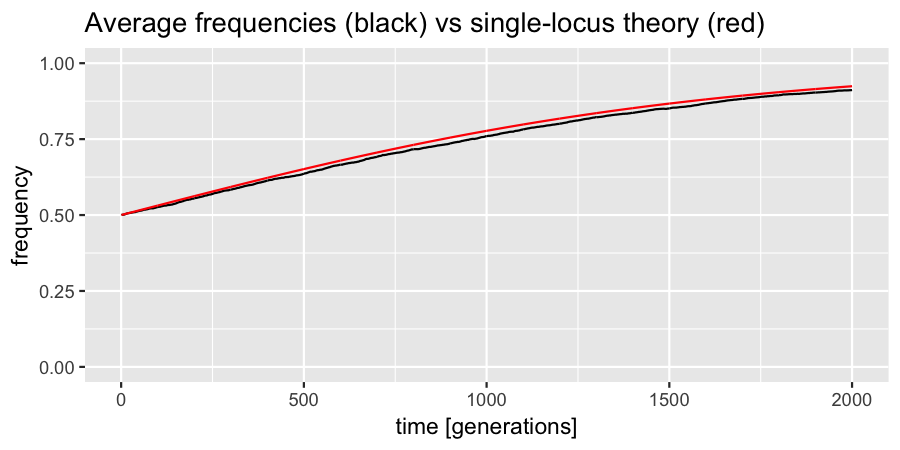

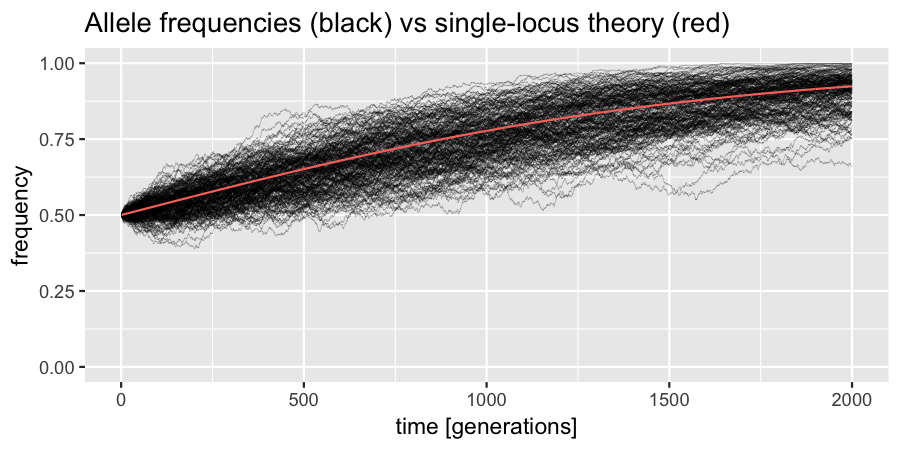

In [7]:
simulate_and_plot(p0 = 0.5, s = 0.0025, total_time = 2000, N_loci = 200, Ne = 10000)

## Example of the ML procedure on simulated data

We will use the `simulate_selection` function to generale allele frequency time series using known parameters $p_0$ (initial allele frequency in a population) and $s$ (selection coefficient of the mutant allele), and generate a set of data points from this simulated trajectory, approximating a set of noisy ancient DNA samples.

We will then "forget" the known parameters and try to recover them just from the simulated aDNA samples.

**Calculating true underlying frequency trajectory:**

In [8]:
total_time <- 2000 # time range of our simulation in generations (start at generation 1)
sample_times <- sort(sample(1 : total_time, 20)) # ages of 20 aDNA samples

p0 <- 0.03  # true initial frequency
s <- 0.0006 # true selection coefficient
h <- 0.5    # true dominance coefficient

# simulate the trajectories of allele frequency under selection
true_freqs <- simulate_selection(p0, s, h, total_time)

**Simulating aDNA samples**

Given a vector of times in generations and a simulated trajectory of allele frequencies calculated using `simulate_selection` function, we sample individual data points (allele frequencies obtained from $n$ aDNA individuals) at each specified time point (in generations) from a binomial distribution (to simulate noisiness in the data).

In [9]:
sample_datapoints <- function(sample_times, traj) {
    map_dbl(sample_times, ~ mean(rbinom(n_individuals, 1, traj[.x])), gen = sample_times)
}

In [10]:
n_individuals <- 50

# simulate aDNA samples
sample_freqs <- sample_datapoints(sample_times, true_freqs)

Combine "real" data (true, known, allele frequency trajectory) and simulated aDNA frequencies into a single data frame:

In [11]:
data = data.frame(
    gen = 1:total_time,
    true_freq = true_freqs
)
data[sample_times, "sample_freq"] <- sample_freqs

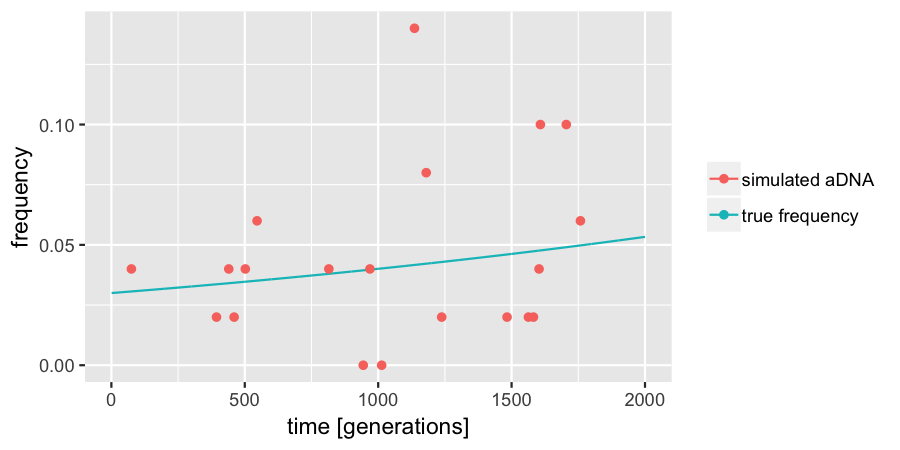

In [12]:
ggplot() +
    geom_line(data = data, aes(gen, true_freq, color = "true frequency")) +
    geom_point(data = data[complete.cases(data), ], aes(gen, sample_freq, color = "simulated aDNA")) +
    labs(x = "time [generations]", y = "frequency") +
    theme(legend.title = element_blank()) +
    expand_limits(y = 0)

Our goal now is to estimate $p_0$ and $s$ using just the red points ("aDNA samples"), ignoring what we know about the true model (blue line).

## Fitting of $s$ and $p_0$ from the aDNA data

### Negative log-likelihood function of the parameters $s$ and $p_0$ given aDNA data

We will calculate the probability of observing an aDNA sample at a given time point as if it was drawn from a binomial distribution with the parameter $p$. In other words, we will calculate the likelihood (actually, the log-likelihood) of the parameters given the data. The overall likelihood for all data points will be calculated by multiplying individual likelihoods together.

In [13]:
negLL <- function(param, data, n) {
    # parameters of the model
    p0 <- param[1] # initial frequency
    s <- param[2]  # selection coefficient
    
    # simulate the frequency trajectory determined by the parameters
    # and subset them to the values at times of aDNA samples
    sim_traj <- as.vector(simulate_selection(p0,
                                             s,
                                             0.5,
                                             total_time = max(data$gen)))
    
    # calculate the negative log-likelihoods of each individual aDNA point
    # (the number of Nea-like SNPs observed on all SNPs available for the sample)
    # given the parameters (actually, given the Nea. trajectory determined
    # by the parameters)
    -sum(dbinom(x = filter(data, complete.cases(data))$sample_freq * n_individuals,
                size = n,
                prob = sim_traj[filter(data, complete.cases(data))$gen],
                log = TRUE))
}

## Maximum likelihood using interative approach

In [14]:
# minimize the negative log-likelihood function, starting from initial frequency 
# of 0.1 and s = -0.1
results <- optim(c(0.1, -0.1), negLL, data = data, n = n_individuals)

Warning message in dbinom(x = filter(data, complete.cases(data))$sample_freq * n_individuals, :
“NaNs produced”

**MLE values** of the $p_0$ and $s$:

In [15]:
(mle_p0 <- results$par[1])
(mle_s <- results$par[2])

[1] 0.02895996

[1] 0.0008345125

**Original values** of the $p_0$ and $s$ for comparison:

In [16]:
p0
s

[1] 0.03

[1] 6e-04

It works! The ML method was able to recover the true parameters $s$ and $p_0$ used for  simulating the data quite accurately.

Let's plot the true frequency trajectory and the estimated trajectory together:

In [17]:
data[, "est_freq"] <- as.vector(simulate_selection(mle_p0, mle_s, 0.5, total_time = max(data$gen)))

Warning message:
“Removed 1980 rows containing missing values (geom_point).”

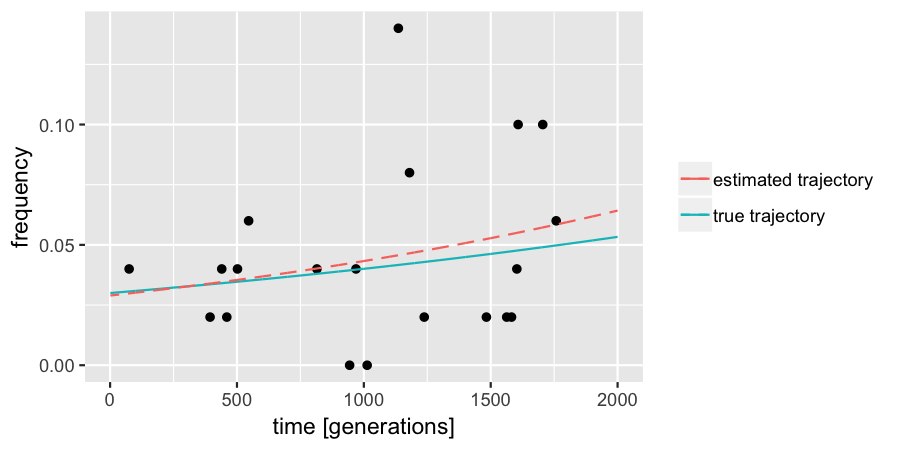

In [18]:
ggplot(data) +
    geom_point(aes(gen, sample_freq)) +
    geom_line(aes(gen, true_freq, color = "true trajectory")) +
    geom_line(aes(gen, est_freq, color = "estimated trajectory"), linetype = 2) +
    labs(x = "time [generations]", y = "frequency") +
    theme(legend.title = element_blank()) +
    expand_limits(y = 0)